Processing

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import pytesseract
from skimage import io, img_as_ubyte
from skimage.transform import rotate
import cv2
from deskew import determine_skew
from concurrent.futures import ThreadPoolExecutor, as_completed


def filter_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(src=image, ddepth=-1, kernel=kernel)


def resize_image(image):
    return cv2.resize(image, (1000, 1000))

def correct_rotation(image, confidence_threshold: int = 10):
    pil_image = Image.fromarray(image)
    osd = pytesseract.image_to_osd(pil_image, output_type=pytesseract.Output.DICT)
    rotate_angle = osd['rotate']
    orientation_conf = osd['orientation_conf']
    
    if orientation_conf < confidence_threshold:
        rotate_angle = 0
    
    corrected_pil_image = pil_image.rotate(-rotate_angle, expand=True)
    return np.array(corrected_pil_image), osd

def deskew(image, resize: bool = True):
    angle = determine_skew(image)
    rotated = rotate(image, angle, resize=resize)
    return img_as_ubyte(np.clip(rotated, 0, 1))

def has_enough_text(image, word_threshold: int = 10):
    text = pytesseract.image_to_string(Image.fromarray(image))
    return len(text.strip().split()) > word_threshold

def has_too_many_black_pixels(image, black_pixel_threshold: float = 0.5, threshold_level: int = 10):
    pixels = np.asarray(image)
    black_pixel_ratio = np.sum(pixels < threshold_level) / pixels.size
    return black_pixel_ratio > black_pixel_threshold

def process_image(image_file, output_directory):
    output_file = os.path.join(output_directory, os.path.basename(image_file))
    try:
        image = io.imread(image_file)
        if has_enough_text(image) and not has_too_many_black_pixels(image):
            try:
                image, osd = correct_rotation(image)
            except Exception:
                pass
            image = deskew(image)
            image = resize_image(image)
            #image = filter_image(image)
            Image.fromarray(image).save(output_file)
            return True, None, output_file
        else:
            Image.fromarray(image).save(output_file)
            return False, "Filtered", output_file
    except Exception as e:
        return False, str(e), None

def process_images(df_all, output_directory: str, batch_size: int, max_images: int):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    image_files = df_all['image_path'].tolist()[:max_images]
    processed_images = []

    with ThreadPoolExecutor(max_workers=batch_size) as executor:
        futures = {executor.submit(process_image, image_file, output_directory): image_file for image_file in image_files}
        for future in as_completed(futures):
            success, reason, output_file = future.result()
            if output_file:
                processed_images.append(output_file)

    print(f"Processed {len(processed_images)} images.")
    return processed_images

def match_labels(processed_images, df_all, output_directory):
    # Filter out None values from processed_images
    processed_images = [image for image in processed_images if image is not None]
    
    processed_file_names = [os.path.basename(image) for image in processed_images]
    processed_df = df_all[df_all['image_path'].apply(lambda x: os.path.basename(x)).isin(processed_file_names)].copy()
    processed_df['processed_image_path'] = processed_df['image_path'].apply(lambda x: os.path.join(output_directory, os.path.basename(x)))
    return processed_df

# Configuration
image_path = 'C:/Users/HP/Desktop/Projet/RVL_dataset/'
output_directory = 'C:/Users/HP/Desktop/projet/correct_RVL_dataset'
batch_size = 1000
max_images = 20000
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Load and combine DataFrames
df_train = pd.read_csv('C:/Users/HP/Desktop/Projet/RVL_dataset/train.csv')
df_val = pd.read_csv('C:/Users/HP/Desktop/Projet/RVL_dataset/validation.csv')
df_test = pd.read_csv('C:/Users/HP/Desktop/Projet/RVL_dataset/test.csv')
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

df_all['Image'] = df_all['Image'].astype(str)
df_all['Label'] = df_all['Label'].astype(int)
df_all['image_path'] = df_all['Image'].apply(lambda x: os.path.join(image_path, x))

processed_images = process_images(df_all, output_directory, batch_size, max_images)
processed_df = match_labels(processed_images, df_all, output_directory)

# Save the DataFrame to CSV
processed_df.to_csv('processed_images_paths.csv', index=False)


Loading the DataFrame 

In [29]:
import pandas as pd

# Load the DataFrame from the CSV file
processed_df = pd.read_csv('processed_images_paths.csv')

# Extracting the relevant columns to create the final DataFrame
final_df = processed_df.drop(['image_path', 'processed_image_path'], axis=1)
final_df


,Image,Label
0,80035521.tif,15
1,513280028.tif,1
2,2053453161.tif,7
3,2040792992_2040792994.tif,10
4,522787731+-7732.tif,3
...,...,...
20011,tob07624.54.tif,9
20012,11291802.tif,14
20013,60001267.tif,14
20014,10402944.tif,6


EfficientNet Model

In [30]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [31]:

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
output_directory = 'C:/Users/HP/Desktop/projet/correct_RVL_dataset'
NUM_CLASSES = 16  


# Custom Dataset Class
class TIFDataset(Dataset):
    def __init__(self, img_dir, dataframe, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Load dataset
dataset = TIFDataset(output_directory, final_df, transform=transform)

Split dataset

In [32]:
# Split dataset
train_size = int(0.5 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Load Pre-trained EfficientNet Model


In [33]:
import torch

torch.cuda.empty_cache()

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'


In [34]:
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained EfficientNetB0 model
model = models.efficientnet_b0(pretrained=True)

# Modify the classifier to fit our number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Training Loop with EfficientNet

In [35]:
import torch.optim as optim

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/10, Loss: 1.4427
Epoch 2/10, Loss: 0.9720
Epoch 3/10, Loss: 0.7979
Epoch 4/10, Loss: 0.6701
Epoch 5/10, Loss: 0.5809
Epoch 6/10, Loss: 0.4889
Epoch 7/10, Loss: 0.4339
Epoch 8/10, Loss: 0.3544
Epoch 9/10, Loss: 0.2971
Epoch 10/10, Loss: 0.2720


Validation Loop

In [36]:
# Validation loop
model.eval()
val_loss = 0.0
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)
val_loss = val_loss / len(val_loader.dataset)
val_accuracy = val_correct.double() / len(val_loader.dataset)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


Validation Loss: 1.0387, Accuracy: 0.7659


Testing Loop

Test Loss: 1.0527, Accuracy: 0.7624


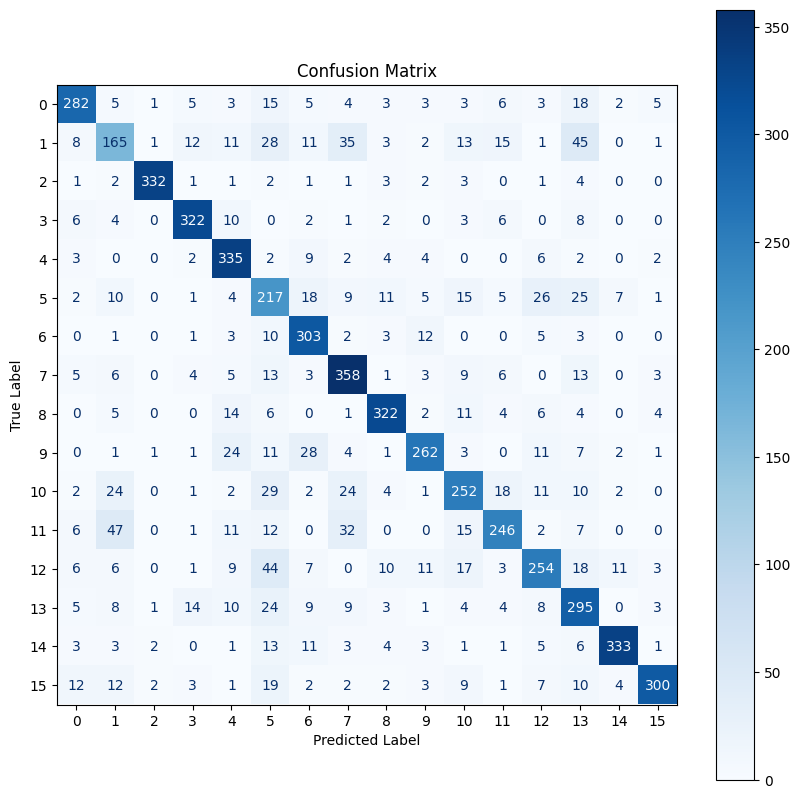

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Testing loop
test_loss = 0.0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) 
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Save the model
torch.save(model.state_dict(), 'model.pth')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Load pretrained model

In [40]:
# Load the pre-trained EfficientNetB0 model
model = models.efficientnet_b0(pretrained=False)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)

# Load the saved state dictionary
model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>